In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.set_printoptions(threshold=5, edgeitems=3)
np.__version__

'1.10.2'

In [3]:
import chainer.cuda as cuda
cuda.available

True

In [4]:
cuda.cudnn_enabled

True

# Dask.Array としてロード

In [5]:
# download.ipynb の変数と同じ
import os

fname = 'cifar-10-python.tar.gz'
datadir = 'data'
tarpath = 'cifar-10-batches-py'

In [6]:
# http://dask.pydata.org/en/latest/array-creation.html
import dask
import dask.array as da
dask.__version__

'0.7.5'

In [7]:
from six.moves import cPickle as pickle

def load(fn):
    # https://www.cs.toronto.edu/~kriz/cifar.html
    with open(os.path.join(datadir, tarpath, fn), 'rb') as f:
        result = pickle.load(f)
    return result

def load_data(fn):
    return load(fn)['data']

def load_labels(fn):
    # list から np.ndarray に変換
    return np.array(load(fn)['labels'])

dsk_data = {('data', i, 0): (load_data, 'data_batch_{0}'.format(i + 1)) for i in range(5)}
dsk_data

{('data', 0, 0): (<function __main__.load_data>, 'data_batch_1'),
 ('data', 1, 0): (<function __main__.load_data>, 'data_batch_2'),
 ('data', 2, 0): (<function __main__.load_data>, 'data_batch_3'),
 ('data', 3, 0): (<function __main__.load_data>, 'data_batch_4'),
 ('data', 4, 0): (<function __main__.load_data>, 'data_batch_5')}

In [8]:
data = da.Array(dsk_data, 'data', chunks=(10000, 3 * 32 * 32),
                dtype=np.float32, shape=(50000, 3 * 32 * 32))
data

dask.array<data, shape=(50000, 3072), dtype=float32, chunksize=(10000, 3072)>

In [9]:
data.compute()

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ..., 
       [ 35,  40,  42, ...,  77,  66,  50],
       [189, 186, 185, ..., 169, 171, 171],
       [229, 236, 234, ..., 173, 162, 161]], dtype=uint8)

In [10]:
data.compute().shape

(50000, 3072)

In [11]:
dsk_labels = {('labels', i): (load_labels, 'data_batch_{0}'.format(i + 1)) for i in range(5)}
dsk_labels

{('labels', 0): (<function __main__.load_labels>, 'data_batch_1'),
 ('labels', 1): (<function __main__.load_labels>, 'data_batch_2'),
 ('labels', 2): (<function __main__.load_labels>, 'data_batch_3'),
 ('labels', 3): (<function __main__.load_labels>, 'data_batch_4'),
 ('labels', 4): (<function __main__.load_labels>, 'data_batch_5')}

In [12]:
labels = da.Array(dsk_labels, 'labels', chunks=(10000, ), shape=(50000, ))
labels

dask.array<labels, shape=(50000,), dtype=None, chunksize=(10000,)>

In [13]:
labels.compute()

array([6, 9, 9, ..., 9, 1, 1])

In [14]:
labels.compute().shape

(50000,)

In [15]:
# テストデータのロード
test_data = load_data('test_batch')
test_labels = load_labels('test_batch')
test_labels

array([3, 8, 8, ..., 5, 1, 7])

# データの確認

In [16]:
nrows = 3
ncols = 10

images = data[0:nrows*ncols, :].compute()
images = images.reshape(nrows*ncols, 3, 32, 32).transpose(0, 2, 3, 1)
images[0].shape

(32, 32, 3)

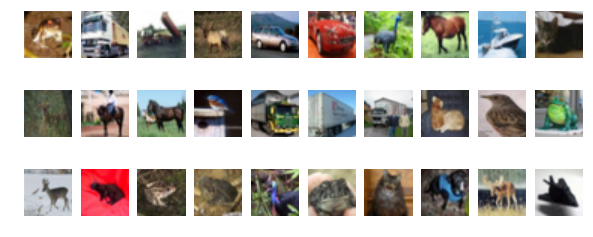

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
for im, ax in zip(images, axes.flatten()):
    ax.imshow(im)
    ax.axis('off')

# Chainer 

In [18]:
import chainer 
chainer.__version__

'1.5.1'

In [19]:
import chainer.cuda as cuda
cuda.available

True

In [20]:
cuda.cudnn_enabled

True

In [21]:
def data_transformer(x):
    # 各レコード 1 次元のデータを 3次元 (3, 32, 32) に変換する 
    return x.astype(np.float32).reshape(len(x), 3, 32, 32) 

def labels_transformer(y):
    return y.astype(np.int32)

In [22]:
from chainer import optimizers
from chainer import Variable

import chainer.functions as F
import chainer.links as L

class Cifar10(chainer.Chain):

    def __init__(self):
        super(Cifar10, self).__init__(
            conv1=L.Convolution2D(3, 32, 5, stride=1, pad=2),
            conv2=L.Convolution2D(32, 32, 5, stride=1, pad=2),
            conv3=L.Convolution2D(32, 64, 5, stride=1, pad=2),
            fc4=F.Linear(1344, 4096),
            fc5=F.Linear(4096, 10),
        )

    def _internal_call(self, x, t, train=True):
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 3, stride=2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.spatial_pyramid_pooling_2d(h, 3, F.MaxPooling2D)
        h = F.dropout(F.relu(self.fc4(h)), ratio=0.5, train=train)
        h = self.fc5(h)
        return h

    def __call__(self, x, t):
        h = self._internal_call(x, t, train=True)
        self.loss = F.softmax_cross_entropy(h, t)
        self.accuracy = F.accuracy(h, t)
        return self.loss

    def predict(self, x, t):
        """ データに対する予測値 (ラベル) を返す """
        h = self._internal_call(x, t, train=False)
        self.pred = F.softmax(h)
        return self.pred.data.argmax(axis=1)

In [23]:
optimizer = optimizers.Adam(alpha=0.001)
model = Cifar10()

In [24]:
if cuda.available:
    xp = cuda.cupy 
    model.to_gpu()
else:
    xp = np

optimizer.setup(model)
optimizer.target

In [25]:
tr_data = data_transformer(data.compute())
tr_labels = labels_transformer(labels.compute())
te_data = data_transformer(test_data)
te_labels = labels_transformer(test_labels)

In [26]:
import time

LOGFILE_HEADER = ['Time elapsed', 'Total num', 'Current num', 'Loss', 'Accuracy']

def write_log(logfile, elapsed, total, current, loss, acc):
    if logfile is None:
        return

    if not os.path.exists(logfile):
        with open(logfile, 'w') as f:
            f.write(','.join(LOGFILE_HEADER))
            f.write(os.linesep)
        
    with open(logfile, 'a') as f:
        line = [elapsed, total, current, loss, acc]
        line = [str(i) for i in line]
        f.write(','.join(line))
        f.write(os.linesep)


In [27]:
def run_epoch(optimizer, model, data, labels, train=True,
              batch_size=100, start_time=None, logfile=None):

    sum_accuracy = 0
    sum_loss = 0
    num = 0
    total = len(labels)
    
    if start_time is None:
        start_time = time.time()
    
    if train:
        indexer = np.random.permutation(len(labels))
        data = data[indexer]
        labels = labels[indexer]

    for index in range(0, total, batch_size):
        x = data[index:index+batch_size]
        t = labels[index:index+batch_size]

        volatile = 'off' if train else 'on'    
        x = Variable(xp.asarray(x), volatile=volatile)
        t = Variable(xp.asarray(t), volatile=volatile)

        if train:
            optimizer.update(model, x, t)
            sum_loss += float(model.loss.data) * len(t)
            sum_accuracy += float(model.accuracy.data) * len(t)
        else:
            predicted = model.predict(x, t)
            acc = float((predicted == t.data).sum())
            sum_loss = np.nan
            sum_accuracy += acc

        num += len(t)   
            
        if num % 100 == 0:
            elapsed = time.time() - start_time
            loss = sum_loss / num
            acc = sum_accuracy / num
            write_log(logfile, elapsed, num, total, loss, acc)
            
            if num % 10000 == 0:
                msg = '{:>8.3f}:\t{:05d}/{:05d}\tloss={:.3f}\tacc={:.3f}'
                print(msg.format(elapsed, num, total, loss, acc)) 

    return sum_accuracy, sum_loss

In [28]:
EPOCHS = 20
start_time = time.time()

logdir = 'log'

if not os.path.exists(logdir):
    os.mkdir(logdir)
train_log = os.path.join(logdir, 'single_gpu_train.log')
test_log = os.path.join(logdir, 'single_gpu_test.log')

np.random.seed(71)

for epoch in range(0, EPOCHS):
    
    print('******************** Epoch {:02d} (Train) ********************'.format(epoch + 1))
    acc, loss = run_epoch(optimizer, model, tr_data, tr_labels,
                          train=True, start_time=start_time, logfile=train_log)
  
    print('******************** Epoch {:02d} (Test) *********************'.format(epoch + 1))
    acc, loss = run_epoch(optimizer, model, te_data, te_labels,
                          train=False, start_time=start_time, logfile=test_log)
    

******************** Epoch 01 (Train) ********************
   4.091:	10000/50000	loss=10.164	acc=0.123
   7.329:	20000/50000	loss=6.162	acc=0.150
  10.570:	30000/50000	loss=4.788	acc=0.177
  13.812:	40000/50000	loss=4.064	acc=0.205
  17.056:	50000/50000	loss=3.612	acc=0.231
******************** Epoch 01 (Test) *********************
  18.140:	10000/10000	loss=nan	acc=0.380
******************** Epoch 02 (Train) ********************
  21.751:	10000/50000	loss=1.746	acc=0.366
  24.985:	20000/50000	loss=1.723	acc=0.372
  28.257:	30000/50000	loss=1.699	acc=0.380
  31.535:	40000/50000	loss=1.682	acc=0.385
  34.794:	50000/50000	loss=1.661	acc=0.393
******************** Epoch 02 (Test) *********************
  35.877:	10000/10000	loss=nan	acc=0.439
******************** Epoch 03 (Train) ********************
  39.504:	10000/50000	loss=1.520	acc=0.447
  42.754:	20000/50000	loss=1.526	acc=0.445
  46.014:	30000/50000	loss=1.514	acc=0.453
  49.270:	40000/50000	loss=1.508	acc=0.454
  52.527:	50000/5000

# Multi GPU

In [29]:
class GPUDistributedGradient(chainer.Chain):

    def __init__(self, chain, ngpus):

        if isinstance(ngpus, int):
            ngpus = list(range(ngpus))
        elif isinstance(ngpus, list):
            pass
        else:
            msg = 'ngpus must be int or list, {0} is given'
            raise ValueError(msg.format(type(ngpus)))

        if len(ngpus) <= 1:
            raise ValueError('Target devices must be longer than 1')

        self.ngpus = ngpus
        self._chains = [chain.copy().to_gpu(i) for i in ngpus]
    
    @property
    def master(self):
        """ 最初の GPU にあるモデルをマスターとする """
        return self._chains[0]
    
    def __call__(self, *args):
        """ 引数毎に 'Variable のリスト' を渡す"""
        if len(args) == 0:
            raise ValueError('no arguments passed')
            
        for i, arg in enumerate(args):
            
            if not isinstance(arg, list):
                msg = 'all arguments must be a list: arg #{0}, {1}'
                raise ValueError(msg.format(i, arg))
                
            if len(arg) != len(self.ngpus):
                msg = 'all arguments must be a list of length {0}: arg #{1}, length {2}'
                raise ValueError(msg.format(len(arg), i, len(self.ngpus)))
                
            if not all(isinstance(a, Variable) for a in arg):
                msg = 'all arguments can only contain Variable: arg#{0}, {1}'
                raise ValueError(msg.format(i, a))
                
        self._losses = [chain(*arg) for chain, arg in zip(self._chains, zip(*args))]
        return self._losses[0]
    
    def predict(self, x, t):
        """ 予測値はマスターで計算し、(まだ) 並列化しない """
        return self.master.predict(x, t)
    
    def zerograds(self):
        for chain in self._chains:
            chain.zerograds()

    def backward(self):
        for loss in self._losses:
            loss.backward()
            
    def syncgrads(self):
        """ 各 GPU からの勾配をマスターに加算する """
        for chain in self._chains[1:]:
            self.master.addgrads(chain)
    
    def __enter__(self):
        self.zerograds()
        return self
    
    def __exit__(self, exception_type, exception_value, traceback):
        self.backward()
        self.syncgrads()
        return True

    def syncparams(self):
        """ マスターのパラメータを他 GPU のモデルにコピーする """
        for chain in self._chains[1:]:
            chain.copyparams(self.master)

In [30]:
NGPU = 4

optimizer = optimizers.Adam(alpha=0.001)
model = Cifar10()
model = GPUDistributedGradient(model, NGPU)

optimizer.setup(model.master)
optimizer.target

In [31]:
def run_epoch_parallel(optimizer, model, data, labels, train=True,
                       batch_size=100, start_time=None, logfile=None):

    sum_accuracy = 0
    sum_loss = 0
    num = 0
    total = len(labels)
    
    if start_time is None:
        start_time = time.time()
    
    if train:
        indexer = np.random.permutation(len(labels))
        data = data[indexer]
        labels = labels[indexer]
        batch_size = batch_size * NGPU

    for index in range(0, total, batch_size):
        x = data[index:index+batch_size]
        t = labels[index:index+batch_size]

        if train:
            # train 時には 利用する GPU と同じ長さの Variable のリストを渡す
            x = [Variable(cuda.to_gpu(v, i)) for i, v in enumerate(np.array_split(x, NGPU))]
            t = [Variable(cuda.to_gpu(v, i)) for i, v in enumerate(np.array_split(t, NGPU))]
        else:  
            x = Variable(xp.asarray(x), volatile='on')
            t = Variable(xp.asarray(t), volatile='on')

        if train:
            with model as m:
                m(x, t)
            optimizer.update()
            model.syncparams()   

            n = sum([len(_t) for _t in t])
            sum_loss += float(model.master.loss.data) * n
            sum_accuracy += float(model.master.accuracy.data) * n
            num += n
        else:
            predicted = model.predict(x, t)
            acc = float((predicted == t.data).sum())
            sum_loss = np.nan
            sum_accuracy += acc
            num += len(t)   
            
        if num % 100 == 0:
            elapsed = time.time() - start_time
            loss = sum_loss / num
            acc = sum_accuracy / num
            write_log(logfile, elapsed, num, total, loss, acc)
            
            if num % 10000 == 0:
                msg = '{:>8.3f}:\t{:05d}/{:05d}\tloss={:.3f}\tacc={:.3f}'
                print(msg.format(elapsed, num, total, loss, acc)) 

    return sum_accuracy, sum_loss

In [33]:
EPOCHS = 20
start_time = time.time()

logdir = 'log'
if not os.path.exists(logdir):
    os.mkdir(logdir)
train_log = os.path.join(logdir, 'multi_gpu_train.log')
test_log = os.path.join(logdir, 'multi_gpu_test.log')

np.random.seed(71)

for epoch in range(0, EPOCHS):
    
    print('******************** Epoch {:02d} (Train) ********************'.format(epoch + 1))
    acc, loss = run_epoch_parallel(optimizer, model, tr_data, tr_labels,
                          train=True, start_time=start_time, logfile=train_log)
  
    print('******************** Epoch {:02d} (Test) *********************'.format(epoch + 1))
    acc, loss = run_epoch_parallel(optimizer, model, te_data, te_labels,
                          train=False, start_time=start_time, logfile=test_log)

******************** Epoch 01 (Train) ********************
   2.870:	10000/50000	loss=1.438	acc=0.479
   5.439:	20000/50000	loss=1.431	acc=0.480
   8.008:	30000/50000	loss=1.417	acc=0.488
  10.595:	40000/50000	loss=1.416	acc=0.491
  13.155:	50000/50000	loss=1.405	acc=0.492
******************** Epoch 01 (Test) *********************
  14.243:	10000/10000	loss=nan	acc=0.517
******************** Epoch 02 (Train) ********************
  17.053:	10000/50000	loss=1.319	acc=0.522
  19.534:	20000/50000	loss=1.313	acc=0.531
  22.018:	30000/50000	loss=1.328	acc=0.521
  24.519:	40000/50000	loss=1.316	acc=0.528
  26.997:	50000/50000	loss=1.312	acc=0.528
******************** Epoch 02 (Test) *********************
  28.067:	10000/10000	loss=nan	acc=0.533
******************** Epoch 03 (Train) ********************
  30.851:	10000/50000	loss=1.237	acc=0.563
  33.314:	20000/50000	loss=1.225	acc=0.559
  35.792:	30000/50000	loss=1.235	acc=0.555
  38.384:	40000/50000	loss=1.246	acc=0.552
  40.869:	50000/50000